In [40]:
import numpy as np
from PIL import Image

from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, Dense
from tensorflow.keras.models import Model

In [3]:
img = Image.open('gato.jpeg')

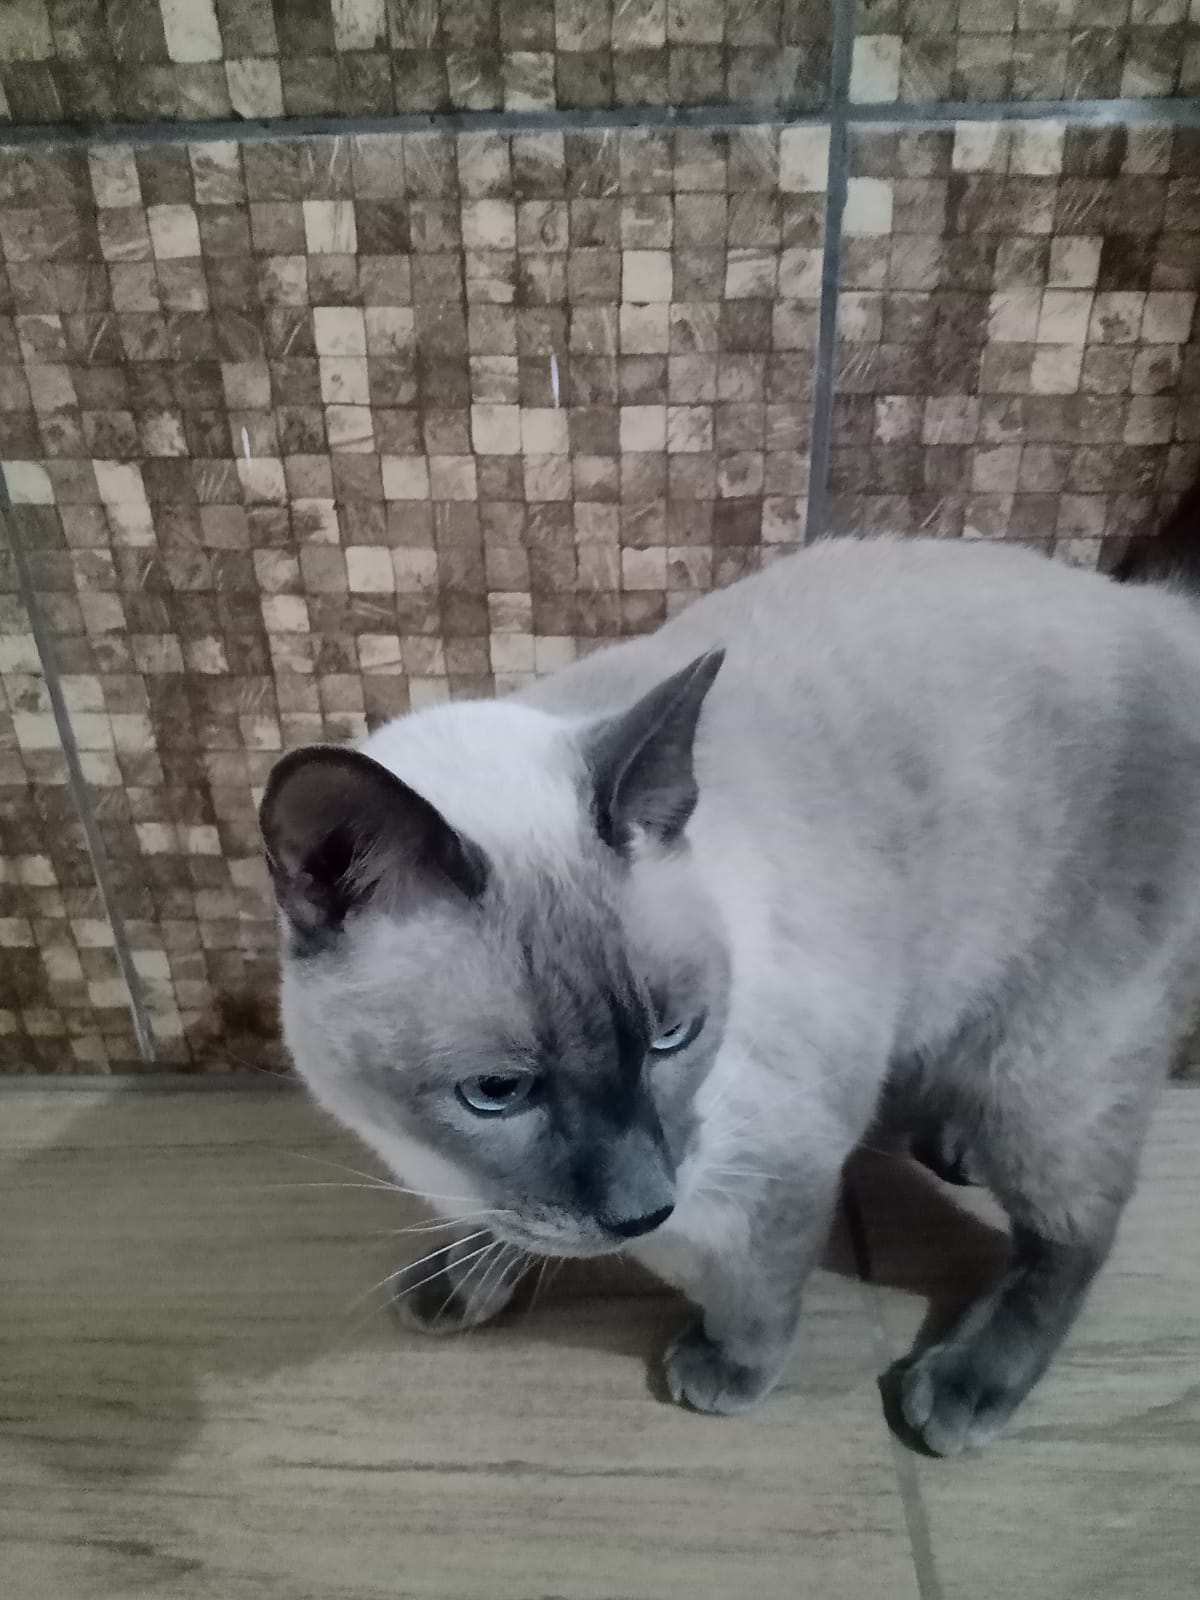

In [7]:
img

In [4]:
img.size

(1200, 1600)

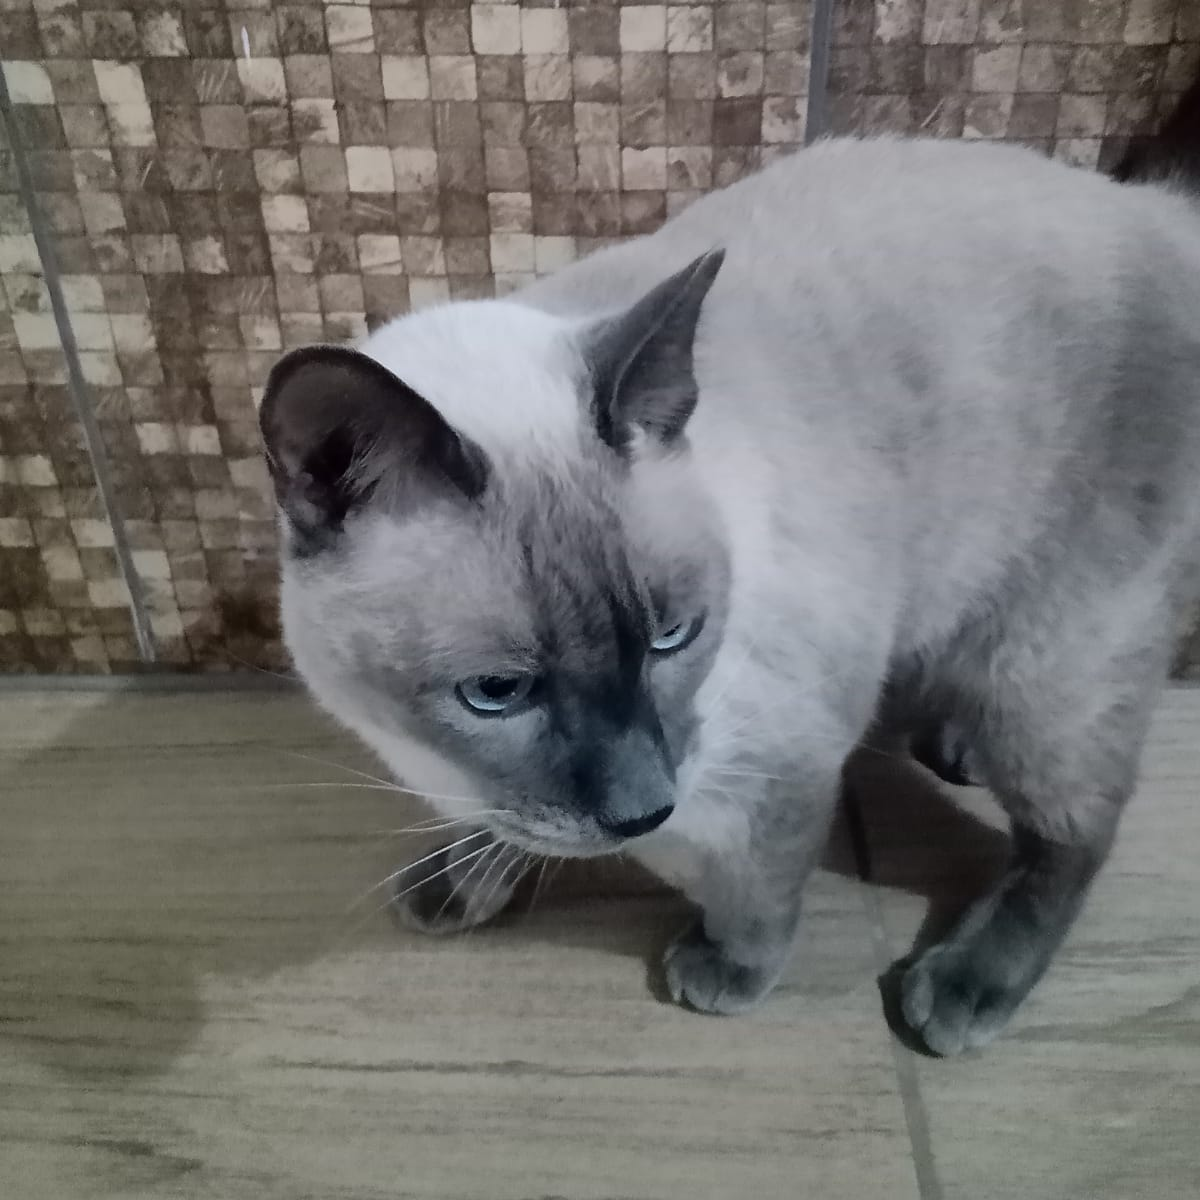

In [9]:
img = img.crop((0, 400, 1200, 1600))
img

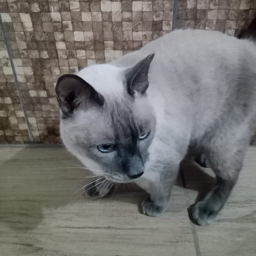

In [14]:
x = img.resize((256, 256))
x

In [17]:
x = np.array(x)
x.shape, x.dtype

((256, 256, 3), dtype('uint8'))

In [28]:
m = x.mean(axis=(0,1))
v = x.var(axis=(0,1))
(x - m).mean(axis=(0,1))

array([0., 0., 0.])

In [29]:
def normalize_input(x):
    _mean = np.array([115., 114., 112.])
    _var = np.array([1450., 1510., 1700.])
    return (x - _mean) / (_var + 1e-10)

In [35]:
x0 = normalize_input(x)

In [36]:
def block(x, filters, kernel_size=3, stride=1):

    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)


    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)

    x = Add()([x, shortcut])
    #x = ReLU()(x)
    return x

In [37]:
def residual_block(x, filters, kernel_size=3, stride=1):

    shortcut = x

    x = block(x, filters, kernel_size=kernel_size, stride=stride)
    x = block(x, filters, kernel_size=kernel_size, stride=stride)
    x = block(x, filters, kernel_size=kernel_size, stride=stride)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)

    x = Add()([x, shortcut])
    
    return x

In [45]:
def build_encoder(input_shape=(64,64, 128), latent_dim=64):
    stride = 1
    filters = 128
    input_tensor = Input(shape=input_shape)
    
    shortcut = input_tensor

    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)

    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)

    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)
    x = residual_block(x, filters, stride)

    x = block(x, filters, kernel_size=3, stride = 1)

    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)


    x = Add()([x, shortcut])

    x = Conv2D(filters, kernel_size=5, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
   
    x = Flatten()(x)
    z = Dense(latent_dim)(x)  
    
    encoder = Model(input_tensor, z, name="encoder")
    return encoder

In [46]:
encoder = build_encoder()

ValueError: Inputs have incompatible shapes. Received shapes (16, 16, 128) and (64, 64, 128)